In [1]:
import numpy as np
np.set_printoptions(precision=3)
import time

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pymc3 as pm

In [7]:
import platform
import theano as tt
print('python:',platform.python_version())
print('numpy:',np.__version__)
print('pymc3:',pm.__version__)
print('theano:',tt.__version__)

python: 3.6.7
numpy: 1.15.4
pymc3: 3.5
theano: 1.0.3


In [2]:
def traceFunc(covModel,noiseModel,noiseHyper,seedN,printErrors=False,plotTrace=False,plotLatent=False):

    np.random.seed(seedN)

    N = 100
    X = np.linspace(0, 10, N)[:, None]

    if covModel == 'simple':
        l_true = 1.0
        n_true = 3.0
        cov_true = n_true**2 * pm.gp.cov.Matern52(1, l_true) + pm.gp.cov.WhiteNoise(0.001)

    mean_true = pm.gp.mean.Zero()

    f_true = np.random.multivariate_normal(mean_true(X).eval(),cov_true(X).eval(),1).flatten()

    if noiseModel == 'studentT':
        s_true = 2
        v_true = 3
        y = f_true + s_true * np.random.standard_t(v_true, size=N)
    elif noiseModel == 'normal':
        m_true = 0
        s_true = 2
        y = f_true + np.random.normal(m_true,s_true, size=N)

    avgYerror = np.mean(np.abs(y - f_true))

    with pm.Model() as model:
        if covModel == 'simple':
            l = pm.Gamma('l', alpha=2, beta=1)
            n = pm.HalfCauchy('n', beta=5)
            cov = n**2 * pm.gp.cov.Matern52(1, l)

        gp = pm.gp.Latent(cov_func=cov)
        f = gp.prior('f', X=X)

        if noiseModel == 'studentT':
            if noiseHyper:
                s = pm.HalfCauchy('s', beta=5)
                v = pm.Gamma('v', alpha=2, beta=0.1)
                y_ = pm.StudentT('y', mu=f, lam=1/s, nu=v, observed=y)
            else:
                y_ = pm.StudentT('y', mu=f, lam=1/s_true, nu=v_true, observed=y)
        elif noiseModel == 'normal':
            if noiseHyper:
                s = pm.HalfCauchy('s', beta=5)
                y_ = pm.Normal('y', mu=f, sd=s, observed=y)
            else:
                y_ = pm.Normal('y', mu=f, sd=s_true, observed=y)

        trace = pm.sample(1000,tune=2000,chains=1)

    meanTrace_f = np.mean(trace['f'],axis=0)
    meanTrace_l = np.mean(trace['l'])
    meanTrace_n = np.mean(trace['n'])
    
    avgY_error = np.mean(np.abs(meanTrace_f - f_true))
    avgL_error = np.mean(np.abs(meanTrace_l - l_true))
    avgN_error = np.mean(np.abs(meanTrace_n - n_true))

    if printErrors:
        print('Avg y - f_true error:',avgYerror)
        print('Avg mean y_ - f_true error:',avgY_error)
        print('Avg mean l_ - l_true error:',avgL_error)
        print('Avg mean n_ - n_true error:',avgN_error)

    if plotTrace:
        pm.traceplot(trace, lines={'l':l_true,'n':n_true}, varnames=['l','n'])
        plt.show()
        
    if plotLatent:
        fig = plt.figure(figsize=(12,5)); ax = fig.gca()
        ax.plot(X, f_true, 'dodgerblue', lw=3, label='True latent f')
        ax.plot(X, y, 'ok', ms=3, label='Data');
        ax.plot(X, meanTrace_f, 'r', lw=3, label='mean of GP post samples')
        ax.set_xlabel('X'); ax.set_ylabel('y'); plt.legend();
        plt.ylim([-20,15])
        plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, n, l]
100%|██████████| 3000/3000 [06:37<00:00,  9.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/tyler/venv_py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


Avg y - f_true error: 2.5840607420273334
Avg mean y_ - f_true error: 0.9391597467788644
Avg mean l_ - l_true error: 0.017081659261566573
Avg mean n_ - n_true error: 0.7956149684831355


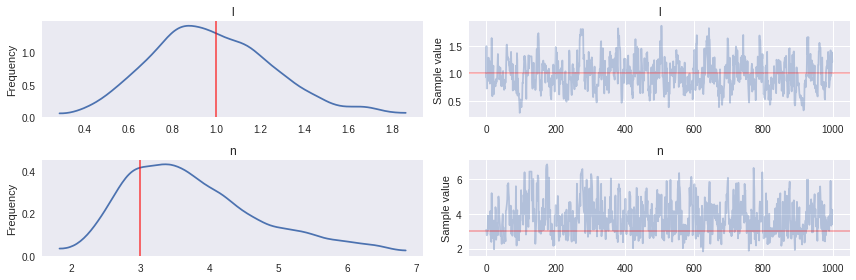

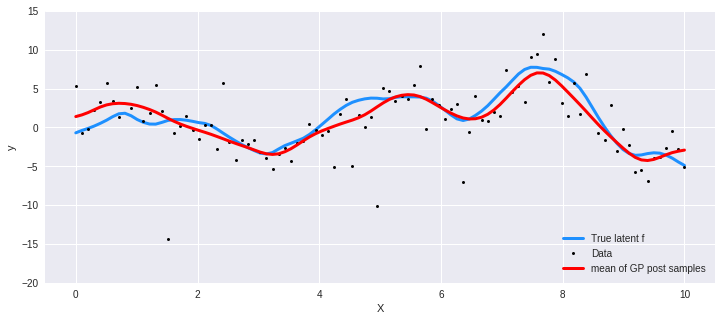

In [3]:
traceFunc('simple','studentT',False,123,True,True,True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [v, s, f_rotated_, n, l]
100%|██████████| 3000/3000 [06:10<00:00,  9.20it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/tyler/venv_py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


Avg y - f_true error: 2.5840607420273334
Avg mean y_ - f_true error: 0.9580876574726475
Avg mean l_ - l_true error: 0.09657492307129889
Avg mean n_ - n_true error: 0.7942687753358673


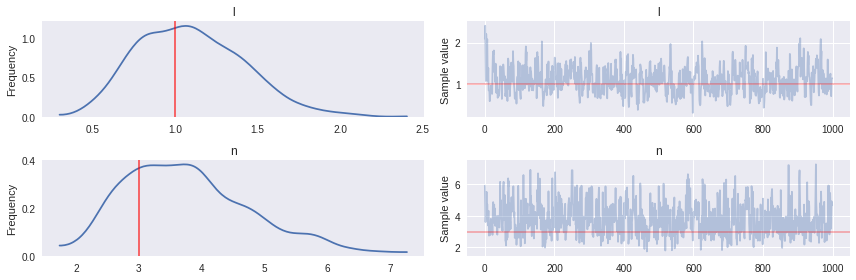

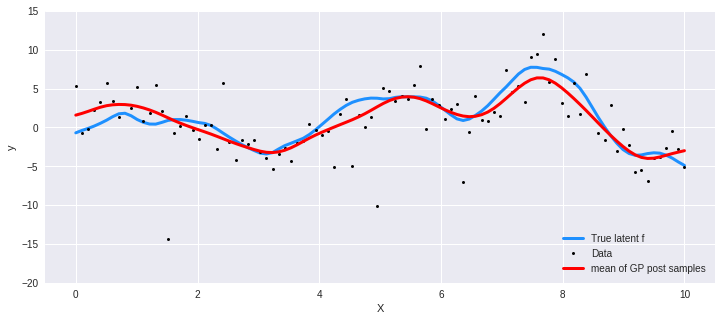

In [4]:
traceFunc('simple','studentT',True,123,True,True,True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, n, l]
100%|██████████| 3000/3000 [06:40<00:00,  9.45it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/tyler/venv_py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


Avg y - f_true error: 1.4425298974114604
Avg mean y_ - f_true error: 0.49073021556093016
Avg mean l_ - l_true error: 0.018978792401212807
Avg mean n_ - n_true error: 1.06117720327671


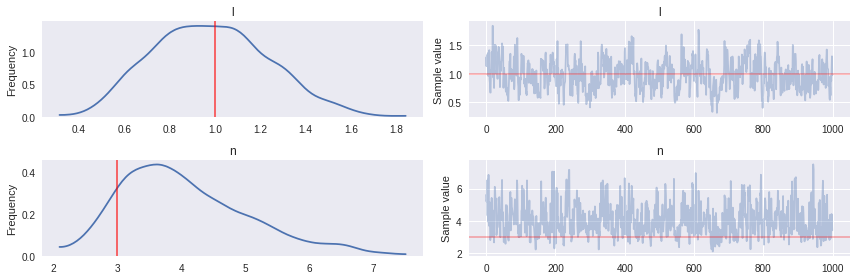

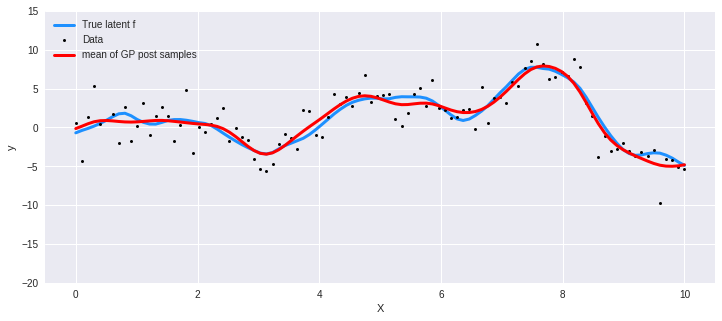

In [5]:
traceFunc('simple','normal',False,123,True,True,True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [s, f_rotated_, n, l]
100%|██████████| 3000/3000 [06:47<00:00,  9.50it/s]
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6678650631614693, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/tyler/venv_py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


Avg y - f_true error: 1.4425298974114604
Avg mean y_ - f_true error: 0.48016740875335856
Avg mean l_ - l_true error: 0.10672797401616596
Avg mean n_ - n_true error: 1.6766996542278765


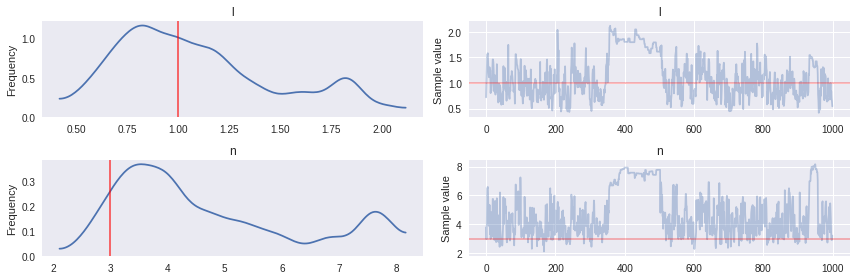

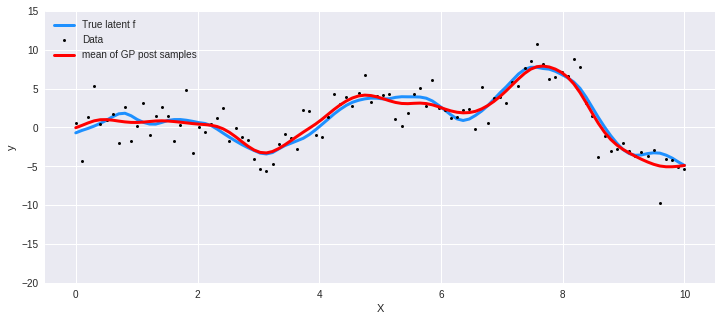

In [6]:
traceFunc('simple','normal',True,123,True,True,True)